## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. <br>
Use fixed parameters, but input datasets with very short syllable removed. <br>
Run one bird at a time

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
bd = 'pair4RigBCU53'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,8.5]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use
rn = 'spec_goffinet_cutoff_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'cosine'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20, 'select_method':'leaf'}

## 2. Train VAE, obtain latent features

In [6]:
fd_save = os.path.join(fd_data, bd, 'UMAPonVAE6', sylStr, rn)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)

print(f'Processing for {bd} {rn}...')
print(f'Save results to {fd_save}')
## load spectrograms and meta info
fn_spec = os.path.join(fd_data, bd, 'Spectrogram4', sylStr, f'{bd}.{sylStr}.{rn}.h5')
fn_info = os.path.join(fd_data, bd, 'Spectrogram4', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
with h5py.File(fn_spec, 'r') as f:
    spec_win_all = f['spec_win_all'][:]  #

info = pd.read_csv(fn_info, index_col=0)

print(spec_win_all.shape, info.shape)

Processing for pair4RigBCU53 spec_goffinet_cutoff_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/UMAPonVAE6/v/spec_goffinet_cutoff_256_176
(16159, 128, 128) (16159, 7)


In [7]:
## train VAE network
# create dataloader from h5 file
train_data = vae_goffinet.SpecDataset(fn_spec)
# set a random seed
g = torch.Generator()
g.manual_seed(42)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
loaders = {'train':train_dataloader, 'test':train_dataloader}

# init VAE model then train
model = vae_goffinet.VAE(save_dir=fd_save)
model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

# save model
fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
model.save_state(fn_model)

Training: epochs 0 to 50
Training set: 16159
Test set: 16159


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 9432.2665
Epoch: 1 Average loss: 1042.3594
Epoch: 2 Average loss: 796.4788
Epoch: 3 Average loss: 657.7955
Epoch: 4 Average loss: 569.7399
Epoch: 5 Average loss: 522.8919
Epoch: 6 Average loss: 486.2312
Epoch: 7 Average loss: 459.3331
Epoch: 8 Average loss: 435.2115
Epoch: 9 Average loss: 414.4789
Epoch: 10 Average loss: 399.8982
Epoch: 11 Average loss: 381.7316
Epoch: 12 Average loss: 368.0312
Epoch: 13 Average loss: 355.8834
Epoch: 14 Average loss: 349.1772
Epoch: 15 Average loss: 342.2080
Epoch: 16 Average loss: 334.7528
Epoch: 17 Average loss: 324.6422
Epoch: 18 Average loss: 319.4292
Epoch: 19 Average loss: 313.7812
Epoch: 20 Average loss: 310.6302
Epoch: 21 Average loss: 305.5242
Epoch: 22 Average loss: 299.0381
Epoch: 23 Average loss: 294.8357
Epoch: 24 Average loss: 291.4938
Epoch: 25 Average loss: 290.0737
Epoch: 26 Average loss: 284.3149
Epoch: 27 Average loss: 280.3572
Epoch: 28 Average loss: 278.2295
Epoch: 29 Average loss: 276.2984
Epoch: 30 Average 

In [8]:
## Obtain latent representation
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

# loop through dataloader, obtain model latent space
latent_m = np.zeros((info.shape[0], 32))
latent_d = np.zeros((info.shape[0], 32))
recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data.to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = rec.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        recon[count:(count+a),:,:] = rec
        count += a

# save the latent representations
fn_latentM = os.path.join(fd_save, 'latentM.csv')
np.savetxt(fn_latentM, latent_m, delimiter=',')
fn_latentD = os.path.join(fd_save, 'latentD.csv')
np.savetxt(fn_latentD, latent_d, delimiter=',')
print(latent_m.shape)

253it [00:18, 13.76it/s]


(16159, 32)


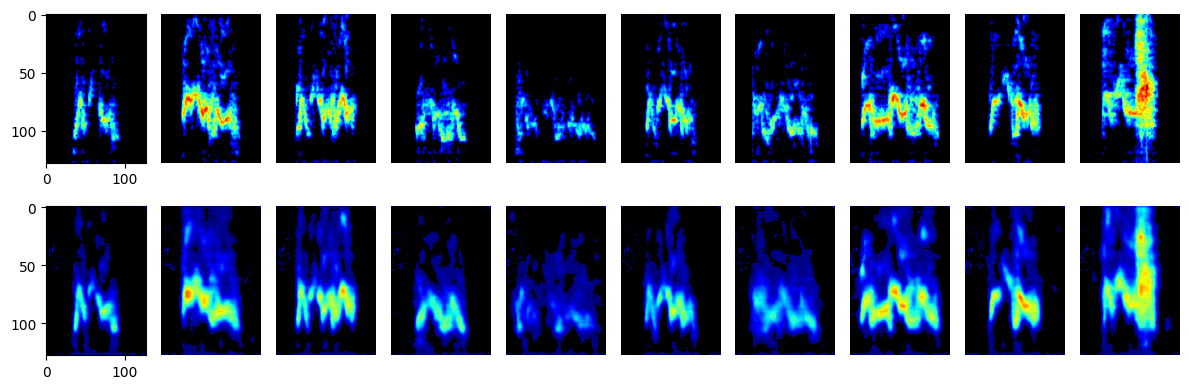

In [9]:
## check recontruction accuracy (optional)
# plot some random samples
fig, ax = plt.subplots(2, 10, figsize=[12,4])
random.seed(1118)
random_i = random.sample(list(range(recon.shape[0])), 10)
with h5py.File(fn_spec, 'r') as file:
    for ii in range(10):
        spec = train_data[random_i[ii],:,:].numpy()
        ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        spec = recon[random_i[ii],:,:]
        ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        if ii>0:
            ax[0][ii].axis('off')
            ax[1][ii].axis('off')
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
fig.savefig(fn_fig)


## 3. Run UMAP/HDBSCAN

In [10]:
# read latent features
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(16159, 32)

In [11]:
# add latent_m to the embedding data frame
embed = info.copy()
for ii in range(latent_m.shape[1]):
    embed[f'vae{ii}'] = latent_m[:,ii]

### UMAP

In [12]:
## run UMAP 
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_m)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'cosine'}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jun 14 11:37:23 2025 Construct fuzzy simplicial set
Sat Jun 14 11:37:23 2025 Finding Nearest Neighbors
Sat Jun 14 11:37:23 2025 Building RP forest with 11 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sat Jun 14 11:37:26 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sat Jun 14 11:37:33 2025 Finished Nearest Neighbor Search
Sat Jun 14 11:37:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jun 14 11:37:42 2025 Finished embedding


In [13]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Sat Jun 14 11:47:38 2025 Worst tree score: 0.85240423
Sat Jun 14 11:47:38 2025 Mean tree score: 0.86026926
Sat Jun 14 11:47:38 2025 Best tree score: 0.86973204
Sat Jun 14 11:47:40 2025 Forward diversification reduced edges from 403975 to 134807
Sat Jun 14 11:47:41 2025 Reverse diversification reduced edges from 134807 to 134807
Sat Jun 14 11:47:43 2025 Degree pruning reduced edges from 147230 to 147230
Sat Jun 14 11:47:43 2025 Resorting data and graph based on tree order
Sat Jun 14 11:47:43 2025 Building and compiling search function


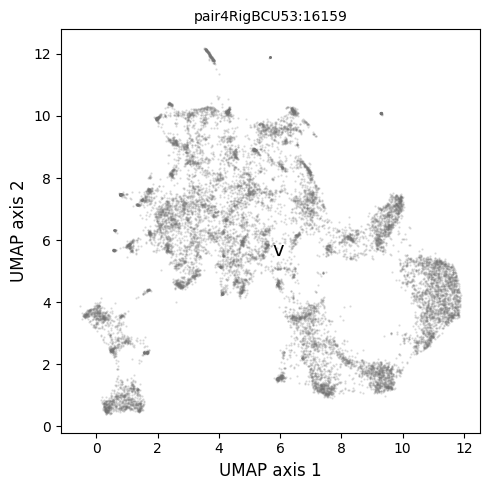

In [14]:
## plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c='#737373')
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.UMAPonVAE.embedding.pdf')
fig.savefig(fn_fig)

### HDBSCAN clustering

In [15]:
int(res.shape[0]* param_hdbscan['min_cluster_size_frac'])

807

In [16]:
## HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
#                             cluster_selection_method=param_hdbscan['select_method'])
clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=param_hdbscan['min_samples'],  
                            cluster_selection_method='leaf')
# clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
clusterer.fit(res)
embed['hdbscan_cluster'] = clusterer.labels_ + 1    # no clustering is label 0
embed['hdbscan_prob'] = clusterer.probabilities_

# save embedding and clustering 
fn_embed = os.path.join(fd_save, f'{bd}.{rn}.embedding.csv')
embed.to_csv(fn_embed)

# what's the fraction that's not clustered
unc_f = embed[embed['hdbscan_cluster']==0].shape[0] / embed.shape[0]
print(f'The fraction that are not clustered: {unc_f:.4f}')
num_c = max(embed['hdbscan_cluster'])
print(f'Total number of clusters: {num_c}')

The fraction that are not clustered: 0.2618
Total number of clusters: 8


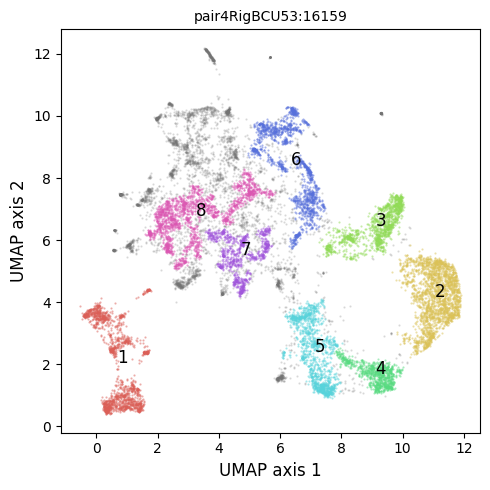

In [17]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster']))
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan_cluster'])+1):
    embed_s = embed[embed['hdbscan_cluster']==hi]
    if hi==0:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi-1])
        # add syl label
        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [18]:
# save HDBSCAN model for future use
fn_cluster = os.path.join(fd_save, f'HDBSCANmodel_{bd}.p')
pickle.dump(clusterer, open(fn_cluster, 'wb'))

In [19]:
# save the color list as well
col_long_np = np.array(col_long)
fn_col = os.path.join(fd_save, 'color.txt')
np.savetxt(fn_col, col_long_np, delimiter=',')

### Quantify clustering quality

In [20]:
## Quantify clustering tendency
# in UMAP space
hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
print(f'Hopkins metric in UMAP: {hpk1:.4f}')
# in VAE space
hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
print(f'Hopkins metric in VAE: {hpk2:.4f}')

## Quantify clustering quality with Silhoutte score
# in UMAP space
sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
# in VAE space
sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

# Calinski–Harabasz (CH) Index
cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

# save data to the master data frame
metrics = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])

Hopkins metric in UMAP: 0.9614
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: 0.2806
HDBSCAN Silhouette score in VAE: 0.0043
Calinski–Harabasz index in UMAP: 9185.1551
Calinski–Harabasz index in VAE: 585.8396


In [21]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigBCU53,spec_goffinet_cutoff_256_176,8,0.261836,"[0.14749024681220682, 0.6629152287609844, 0.38...",0.961402,0.82563,0.280618,0.004252,9185.155089,585.839594,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 4. Simulate the random datasets

In [22]:
# number of trials to simulate
n = 200

In [23]:
# load the real dataset
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(16159, 32)

In [24]:
 # estimated mean and variance
mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
Sigma  = np.cov(latent_m, rowvar=False, ddof=1)

In [ ]:
# save metrics in a master dataframe
metrics = pd.DataFrame()
np.random.seed(2288)
for i in tqdm.tqdm(range(n)):
# for i in range(2):
    rng = np.random.default_rng()  
    latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
    
    # then run UMAP and HDBSCAN exactly as for real datasets
    ## run UMAP 
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    ## HDBSCAN clustering
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
    #                             cluster_selection_method=param_hdbscan['select_method'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=20, 
                                cluster_selection_method='leaf')
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
    clusterer.fit(res)
    
    labs = clusterer.labels_; 
    # what's the fraction that's not clustered
    unc_f = labs[labs==-1].shape[0] / labs.shape[0]
    print(f'The fraction that are not clustered: {unc_f:.4f}')
    num_c = max(labs+1)
    print(f'Total number of clusters: {num_c}')
    
    if num_c==0:
        continue

    ## Quantify clustering tendency
    # in UMAP space
    hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
    print(f'Hopkins metric in UMAP: {hpk1:.4f}')
    # in VAE space
    hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
    print(f'Hopkins metric in VAE: {hpk2:.4f}')

    ## Quantify clustering quality with Silhoutte score
    # in UMAP space
    sil1 = silhouette_score(res, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
    # in VAE space
    sil2 = silhouette_score(latent_m, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

    # Calinski–Harabasz (CH) Index
    cah1 = calinski_harabasz_score(res, labs)
    print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
    cah2 = calinski_harabasz_score(latent_m, labs)
    print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

    # save data to the master data frame
    row = pd.DataFrame([{'birdID':bd, 'run_id':i, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                         'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
    metrics = pd.concat([metrics, row], ignore_index=True)


  0%|          | 0/200 [00:00<?, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:18:11 2025 Construct fuzzy simplicial set
Sun Jun 15 22:18:11 2025 Finding Nearest Neighbors
Sun Jun 15 22:18:11 2025 Building RP forest with 11 trees
Sun Jun 15 22:18:11 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:18:12 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:18:12 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:18:18 2025 Finished embedding
The fraction that are not clustered: 0.5294
Total number of clusters: 4
Hopkins metric in UMAP: 0.8055
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0621



  0%|          | 1/200 [00:12<39:57, 12.05s/it]

HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1969.4054
Calinski–Harabasz index in VAE: 0.8565
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:18:23 2025 Construct fuzzy simplicial set
Sun Jun 15 22:18:23 2025 Finding Nearest Neighbors
Sun Jun 15 22:18:23 2025 Building RP forest with 11 trees
Sun Jun 15 22:18:23 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:18:24 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:18:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:18:30 2025 Finished embedding
The fraction that are not clustered: 0.4591
Total number of clusters: 4
Hopkins metric in UMAP: 0.8428
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0468



  1%|          | 2/200 [00:24<39:43, 12.04s/it]

HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 2185.4071
Calinski–Harabasz index in VAE: 1.4304
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:18:35 2025 Construct fuzzy simplicial set
Sun Jun 15 22:18:35 2025 Finding Nearest Neighbors
Sun Jun 15 22:18:35 2025 Building RP forest with 11 trees
Sun Jun 15 22:18:35 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:18:36 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:18:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:18:42 2025 Finished embedding
The fraction that are not clustered: 0.5011
Total number of clusters: 5
Hopkins metric in UMAP: 0.8227
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0641



  2%|▏         | 3/200 [00:36<39:55, 12.16s/it]

HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 2062.2827
Calinski–Harabasz index in VAE: 0.9001
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:18:47 2025 Construct fuzzy simplicial set
Sun Jun 15 22:18:47 2025 Finding Nearest Neighbors
Sun Jun 15 22:18:47 2025 Building RP forest with 11 trees
Sun Jun 15 22:18:48 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:18:48 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:18:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:18:55 2025 Finished embedding
The fraction that are not clustered: 0.6566
Total number of clusters: 4
Hopkins metric in UMAP: 0.8695
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1882



  2%|▏         | 4/200 [00:48<39:56, 12.23s/it]

HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1206.7379
Calinski–Harabasz index in VAE: 0.8903
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:19:00 2025 Construct fuzzy simplicial set
Sun Jun 15 22:19:00 2025 Finding Nearest Neighbors
Sun Jun 15 22:19:00 2025 Building RP forest with 11 trees
Sun Jun 15 22:19:00 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:19:01 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:19:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:19:07 2025 Finished embedding
The fraction that are not clustered: 0.6095
Total number of clusters: 4
Hopkins metric in UMAP: 0.8571
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1108



  2%|▎         | 5/200 [01:00<39:44, 12.23s/it]

HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 1599.2580
Calinski–Harabasz index in VAE: 0.8025
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:19:12 2025 Construct fuzzy simplicial set
Sun Jun 15 22:19:12 2025 Finding Nearest Neighbors
Sun Jun 15 22:19:12 2025 Building RP forest with 11 trees
Sun Jun 15 22:19:12 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:19:13 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:19:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:19:19 2025 Finished embedding
The fraction that are not clustered: 0.5876
Total number of clusters: 6
Hopkins metric in UMAP: 0.8378
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1618



  3%|▎         | 6/200 [01:13<39:23, 12.19s/it]

HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1483.1379
Calinski–Harabasz index in VAE: 0.7387
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:19:24 2025 Construct fuzzy simplicial set
Sun Jun 15 22:19:24 2025 Finding Nearest Neighbors
Sun Jun 15 22:19:24 2025 Building RP forest with 11 trees
Sun Jun 15 22:19:24 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:19:25 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:19:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:19:31 2025 Finished embedding
The fraction that are not clustered: 0.6349
Total number of clusters: 5
Hopkins metric in UMAP: 0.8536
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1805



  4%|▎         | 7/200 [01:25<39:17, 12.22s/it]

HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 1347.4174
Calinski–Harabasz index in VAE: 0.9063
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:19:36 2025 Construct fuzzy simplicial set
Sun Jun 15 22:19:36 2025 Finding Nearest Neighbors
Sun Jun 15 22:19:36 2025 Building RP forest with 11 trees
Sun Jun 15 22:19:36 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:19:37 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:19:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:19:44 2025 Finished embedding
The fraction that are not clustered: 0.5649
Total number of clusters: 3
Hopkins metric in UMAP: 0.8555
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1288



  4%|▍         | 8/200 [01:37<38:57, 12.18s/it]

HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 820.0544
Calinski–Harabasz index in VAE: 0.8876
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:19:48 2025 Construct fuzzy simplicial set
Sun Jun 15 22:19:48 2025 Finding Nearest Neighbors
Sun Jun 15 22:19:48 2025 Building RP forest with 11 trees
Sun Jun 15 22:19:49 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:19:49 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:19:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:19:56 2025 Finished embedding
The fraction that are not clustered: 0.6469
Total number of clusters: 5
Hopkins metric in UMAP: 0.8486
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1671



  4%|▍         | 9/200 [01:49<39:02, 12.26s/it]

HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 1343.7505
Calinski–Harabasz index in VAE: 0.8578
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:20:01 2025 Construct fuzzy simplicial set
Sun Jun 15 22:20:01 2025 Finding Nearest Neighbors
Sun Jun 15 22:20:01 2025 Building RP forest with 11 trees
Sun Jun 15 22:20:01 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:20:02 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:20:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:20:08 2025 Finished embedding
The fraction that are not clustered: 0.5407
Total number of clusters: 4
Hopkins metric in UMAP: 0.8507
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1084



  5%|▌         | 10/200 [02:01<38:38, 12.20s/it]

HDBSCAN Silhouette score in VAE: -0.0073
Calinski–Harabasz index in UMAP: 1723.7898
Calinski–Harabasz index in VAE: 1.2793
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:20:13 2025 Construct fuzzy simplicial set
Sun Jun 15 22:20:13 2025 Finding Nearest Neighbors
Sun Jun 15 22:20:13 2025 Building RP forest with 11 trees
Sun Jun 15 22:20:13 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:20:14 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:20:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:20:20 2025 Finished embedding
The fraction that are not clustered: 0.5781
Total number of clusters: 4
Hopkins metric in UMAP: 0.8217
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1075



  6%|▌         | 11/200 [02:13<38:17, 12.16s/it]

HDBSCAN Silhouette score in VAE: -0.0067
Calinski–Harabasz index in UMAP: 1615.1857
Calinski–Harabasz index in VAE: 0.8970
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:20:25 2025 Construct fuzzy simplicial set
Sun Jun 15 22:20:25 2025 Finding Nearest Neighbors
Sun Jun 15 22:20:25 2025 Building RP forest with 11 trees
Sun Jun 15 22:20:25 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:20:26 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:20:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:20:32 2025 Finished embedding
The fraction that are not clustered: 0.6921
Total number of clusters: 4
Hopkins metric in UMAP: 0.8516
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1468



  6%|▌         | 12/200 [02:26<38:05, 12.16s/it]

HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1468.7517
Calinski–Harabasz index in VAE: 0.6046
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:20:37 2025 Construct fuzzy simplicial set
Sun Jun 15 22:20:37 2025 Finding Nearest Neighbors
Sun Jun 15 22:20:37 2025 Building RP forest with 11 trees
Sun Jun 15 22:20:37 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:20:38 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:20:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:20:44 2025 Finished embedding
The fraction that are not clustered: 0.5254
Total number of clusters: 3
Hopkins metric in UMAP: 0.8418
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0710



  6%|▋         | 13/200 [02:38<37:52, 12.15s/it]

HDBSCAN Silhouette score in VAE: -0.0022
Calinski–Harabasz index in UMAP: 1524.2548
Calinski–Harabasz index in VAE: 1.0138
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:20:49 2025 Construct fuzzy simplicial set
Sun Jun 15 22:20:49 2025 Finding Nearest Neighbors
Sun Jun 15 22:20:49 2025 Building RP forest with 11 trees
Sun Jun 15 22:20:49 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:20:50 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:20:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:20:57 2025 Finished embedding
The fraction that are not clustered: 0.6971
Total number of clusters: 4
Hopkins metric in UMAP: 0.8223
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1854



  7%|▋         | 14/200 [02:50<37:48, 12.20s/it]

HDBSCAN Silhouette score in VAE: -0.0120
Calinski–Harabasz index in UMAP: 1194.2656
Calinski–Harabasz index in VAE: 1.1815
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:21:02 2025 Construct fuzzy simplicial set
Sun Jun 15 22:21:02 2025 Finding Nearest Neighbors
Sun Jun 15 22:21:02 2025 Building RP forest with 11 trees
Sun Jun 15 22:21:02 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:21:02 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:21:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:21:09 2025 Finished embedding
The fraction that are not clustered: 0.5102
Total number of clusters: 4
Hopkins metric in UMAP: 0.8407
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0690



  8%|▊         | 15/200 [03:02<37:41, 12.22s/it]

HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 2008.5057
Calinski–Harabasz index in VAE: 0.9161
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:21:14 2025 Construct fuzzy simplicial set
Sun Jun 15 22:21:14 2025 Finding Nearest Neighbors
Sun Jun 15 22:21:14 2025 Building RP forest with 11 trees
Sun Jun 15 22:21:14 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:21:15 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:21:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:21:21 2025 Finished embedding
The fraction that are not clustered: 0.6939
Total number of clusters: 4
Hopkins metric in UMAP: 0.8473
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.2045



  8%|▊         | 16/200 [03:15<37:30, 12.23s/it]

HDBSCAN Silhouette score in VAE: -0.0083
Calinski–Harabasz index in UMAP: 973.0070
Calinski–Harabasz index in VAE: 1.4706
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:21:26 2025 Construct fuzzy simplicial set
Sun Jun 15 22:21:26 2025 Finding Nearest Neighbors
Sun Jun 15 22:21:26 2025 Building RP forest with 11 trees
Sun Jun 15 22:21:26 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:21:27 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:21:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:21:33 2025 Finished embedding
The fraction that are not clustered: 0.5469
Total number of clusters: 3
Hopkins metric in UMAP: 0.8313
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0620



  8%|▊         | 17/200 [03:27<37:10, 12.19s/it]

HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 1587.9313
Calinski–Harabasz index in VAE: 0.8788
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:21:38 2025 Construct fuzzy simplicial set
Sun Jun 15 22:21:38 2025 Finding Nearest Neighbors
Sun Jun 15 22:21:38 2025 Building RP forest with 11 trees
Sun Jun 15 22:21:38 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:21:39 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:21:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:21:45 2025 Finished embedding
The fraction that are not clustered: 0.4955
Total number of clusters: 3
Hopkins metric in UMAP: 0.8654
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0437



  9%|▉         | 18/200 [03:39<36:50, 12.15s/it]

HDBSCAN Silhouette score in VAE: -0.0062
Calinski–Harabasz index in UMAP: 1657.9753
Calinski–Harabasz index in VAE: 1.1653
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:21:50 2025 Construct fuzzy simplicial set
Sun Jun 15 22:21:50 2025 Finding Nearest Neighbors
Sun Jun 15 22:21:50 2025 Building RP forest with 11 trees
Sun Jun 15 22:21:50 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:21:51 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:21:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:21:58 2025 Finished embedding
The fraction that are not clustered: 0.6852
Total number of clusters: 4
Hopkins metric in UMAP: 0.8554
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1140



 10%|▉         | 19/200 [03:52<37:58, 12.59s/it]

HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 1758.4153
Calinski–Harabasz index in VAE: 1.1727
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:22:04 2025 Construct fuzzy simplicial set
Sun Jun 15 22:22:04 2025 Finding Nearest Neighbors
Sun Jun 15 22:22:04 2025 Building RP forest with 11 trees
Sun Jun 15 22:22:04 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:22:05 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:22:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:22:11 2025 Finished embedding
The fraction that are not clustered: 0.5645
Total number of clusters: 5
Hopkins metric in UMAP: 0.8228
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1228



 10%|█         | 20/200 [04:04<37:17, 12.43s/it]

HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1828.8856
Calinski–Harabasz index in VAE: 0.6765
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:22:16 2025 Construct fuzzy simplicial set
Sun Jun 15 22:22:16 2025 Finding Nearest Neighbors
Sun Jun 15 22:22:16 2025 Building RP forest with 11 trees
Sun Jun 15 22:22:16 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:22:17 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:22:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:22:24 2025 Finished embedding
The fraction that are not clustered: 0.6187
Total number of clusters: 5
Hopkins metric in UMAP: 0.8247
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1830



 10%|█         | 21/200 [04:17<37:07, 12.44s/it]

HDBSCAN Silhouette score in VAE: -0.0126
Calinski–Harabasz index in UMAP: 1256.1465
Calinski–Harabasz index in VAE: 0.6260
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:22:28 2025 Construct fuzzy simplicial set
Sun Jun 15 22:22:28 2025 Finding Nearest Neighbors
Sun Jun 15 22:22:28 2025 Building RP forest with 11 trees
Sun Jun 15 22:22:29 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:22:29 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:22:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:22:36 2025 Finished embedding
The fraction that are not clustered: 0.5831
Total number of clusters: 3
Hopkins metric in UMAP: 0.8436
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0907



 11%|█         | 22/200 [04:29<36:45, 12.39s/it]

HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 1333.4807
Calinski–Harabasz index in VAE: 0.9829
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:22:41 2025 Construct fuzzy simplicial set
Sun Jun 15 22:22:41 2025 Finding Nearest Neighbors
Sun Jun 15 22:22:41 2025 Building RP forest with 11 trees
Sun Jun 15 22:22:41 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:22:41 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:22:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:22:48 2025 Finished embedding
The fraction that are not clustered: 0.5566
Total number of clusters: 5
Hopkins metric in UMAP: 0.8672
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1224



 12%|█▏        | 23/200 [04:42<36:33, 12.39s/it]

HDBSCAN Silhouette score in VAE: -0.0094
Calinski–Harabasz index in UMAP: 1735.9836
Calinski–Harabasz index in VAE: 1.1104
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:22:53 2025 Construct fuzzy simplicial set
Sun Jun 15 22:22:53 2025 Finding Nearest Neighbors
Sun Jun 15 22:22:53 2025 Building RP forest with 11 trees
Sun Jun 15 22:22:53 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:22:54 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:22:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:01 2025 Finished embedding
The fraction that are not clustered: 0.5070
Total number of clusters: 5
Hopkins metric in UMAP: 0.8392
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1035



 12%|█▏        | 24/200 [04:55<37:27, 12.77s/it]

HDBSCAN Silhouette score in VAE: -0.0079
Calinski–Harabasz index in UMAP: 1904.3123
Calinski–Harabasz index in VAE: 1.1659
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:07 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:07 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:07 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:07 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:23:08 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:14 2025 Finished embedding
The fraction that are not clustered: 0.6027
Total number of clusters: 3
Hopkins metric in UMAP: 0.8544
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.0881



 12%|█▎        | 25/200 [05:09<38:02, 13.04s/it]

HDBSCAN Silhouette score in VAE: -0.0017
Calinski–Harabasz index in UMAP: 1448.1070
Calinski–Harabasz index in VAE: 0.9214
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:20 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:20 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:20 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:21 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:23:21 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:28 2025 Finished embedding
The fraction that are not clustered: 0.6288
Total number of clusters: 3
Hopkins metric in UMAP: 0.8483
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1163



 13%|█▎        | 26/200 [05:23<38:34, 13.30s/it]

HDBSCAN Silhouette score in VAE: -0.0085
Calinski–Harabasz index in UMAP: 1267.9048
Calinski–Harabasz index in VAE: 1.2374
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:34 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:34 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:34 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:34 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:23:35 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:42 2025 Finished embedding
The fraction that are not clustered: 0.6981
Total number of clusters: 3
Hopkins metric in UMAP: 0.8684
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1744



 14%|█▎        | 27/200 [05:37<39:22, 13.66s/it]

HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 1124.0421
Calinski–Harabasz index in VAE: 0.6516
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:23:49 2025 Construct fuzzy simplicial set
Sun Jun 15 22:23:49 2025 Finding Nearest Neighbors
Sun Jun 15 22:23:49 2025 Building RP forest with 11 trees
Sun Jun 15 22:23:49 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:23:50 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:23:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:23:56 2025 Finished embedding
The fraction that are not clustered: 0.8118
Total number of clusters: 3
Hopkins metric in UMAP: 0.8575
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.2446



 14%|█▍        | 28/200 [05:52<39:49, 13.89s/it]

HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 765.0491
Calinski–Harabasz index in VAE: 0.5339
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:24:03 2025 Construct fuzzy simplicial set
Sun Jun 15 22:24:03 2025 Finding Nearest Neighbors
Sun Jun 15 22:24:03 2025 Building RP forest with 11 trees
Sun Jun 15 22:24:03 2025 NN descent for 14 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:24:04 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:24:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Jun 15 22:24:11 2025 Finished embedding
The fraction that are not clustered: 0.5968
Total number of clusters: 4
Hopkins metric in UMAP: 0.8347
Hopkins metric in VAE: 0.8256
HDBSCAN Silhouette score in UMAP: -0.1361



 14%|█▍        | 29/200 [06:06<39:50, 13.98s/it]

HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 1509.9721
Calinski–Harabasz index in VAE: 0.9080
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Jun 15 22:24:17 2025 Construct fuzzy simplicial set
Sun Jun 15 22:24:17 2025 Finding Nearest Neighbors
Sun Jun 15 22:24:17 2025 Building RP forest with 11 trees
Sun Jun 15 22:24:18 2025 NN descent for 14 iterations
	 1  /  14


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sun Jun 15 22:24:18 2025 Finished Nearest Neighbor Search
Sun Jun 15 22:24:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs


In [38]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
print(metrics.shape)
metrics.head()

(199, 13)


,birdID,run_id,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigBCU53,0,4,0.529364,"[0.05805503244239314, 0.056496517349709535, 0....",0.805546,0.82563,-0.062061,-0.002830,1969.405372,0.856485,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
1,pair4RigBCU53,1,4,0.459125,"[0.03248501872339153, 0.04193977816341741, 0.0...",0.842781,0.82563,-0.046795,-0.007148,2185.407108,1.430393,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
2,pair4RigBCU53,2,5,0.501145,"[0.056882374416606915, 0.009410206109998723, 0...",0.822664,0.82563,-0.064056,-0.005472,2062.282676,0.900137,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
3,pair4RigBCU53,3,4,0.656600,"[0.011538131851716888, 0.010936401087462938, 0...",0.869516,0.82563,-0.188219,-0.005734,1206.737884,0.890296,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
4,pair4RigBCU53,4,4,0.609506,"[0.005623733888267856, 0.029671356698939312, 0...",0.857126,0.82563,-0.110771,-0.003955,1599.257976,0.802535,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


### Plot the random distribution of clustering metrics

In [39]:
# read the metric on real dataset
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metric_r = pd.read_csv(fn_metric, index_col=0)
metric_r

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigBCU53,spec_goffinet_cutoff_256_176,8,0.261836,[0.14749025 0.66291523 0.38407508 0.12416376 0...,0.961402,0.82563,0.280618,0.004252,9185.155089,585.839594,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


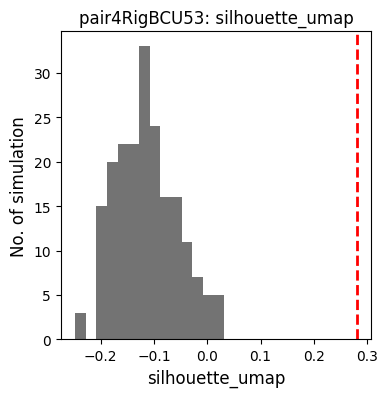

In [40]:
field = 'silhouette_umap'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
d = metrics[field]
bin_width = 0.02
bins = np.arange(min(d), max(d) + bin_width, bin_width)
ax.hist(d, bins=bins, color='#737373', edgecolor='none')
# add a line for the real data
ax.axvline(x=metric_r[field][0], color='red', linestyle='--', linewidth=2)
ax.set_xlabel(field, fontsize=12)
ax.set_ylabel('No. of simulation', fontsize=12)
ax.set_title(f'{bd}: {field}', fontsize=12)
# save as pdf
fn_pdf = os.path.join(fd_save, f'random.hist.{field}.pdf')
fig.savefig(fn_pdf)

### Plot an example random embedding 

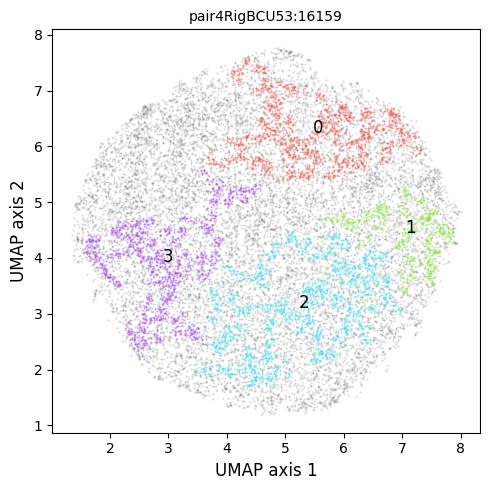

In [41]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(clusterer.labels_)+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(-1, max(clusterer.labels_)+1):
    idx = np.where(clusterer.labels_ == hi)[0]
    embed_s = res[idx,:]
    if hi==-1:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.5, color=col_long[hi])
        # add syl label
        ax.text(np.mean(embed_s[:,0]), np.mean(embed_s[:,1]), hi, fontsize=12)
ax.set_title(f'{bd}:{info.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [42]:
# save the embedding data to plot in Matlab 
embed_r = info.copy()
# save the latent features
for ii in range(latent_rd.shape[1]):
    embed_r[f'vae{ii}'] = latent_rd[:,ii]
# save the UMAP and HDBSCAN results
for ii in range(res.shape[1]):
    embed_r[f'umap{ii+1}'] = res[:,ii]
embed_r['hdbscan_cluster'] = clusterer.labels_+1
embed_r['hdbscan_prob'] = clusterer.probabilities_
fn_csv = os.path.join(fd_save, f'{bd}.random.embedding.csv')
embed_r.to_csv(fn_csv)

In [43]:
print(fn_csv)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/UMAPonVAE6/v/spec_goffinet_cutoff_256_176/pair4RigBCU53.random.embedding.csv


In [44]:
embed_r.shape

(16159, 43)

In [45]:
num_c

4